<a href="https://colab.research.google.com/github/ahmadryan/covid19/blob/master/coronavirus_quick_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install geopandas
!pip install shapely

In [68]:
import pandas as pd
import pylab as pl
import geopandas as gpd
import shapely
import json
import matplotlib as mpl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gray', 'inferno', 'viridis', 'figure', 'plasma', 'show']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
#remove warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [0]:
#bokeh imports
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models import HoverTool
from bokeh.palettes import viridis, inferno, cividis, plasma, gray

In [0]:
# most of the data I grab from online links 
# but the shapefiles downloaded and saved on data/
# the last part of the analysis uses worldbank data 
# which I also downloaded and saved on data/ - that could be changed
#from google.colab import drive

#drive.mount("/content/gdrive")

In [0]:
#cd gdrive/My\ Drive

In [0]:
#cd cv19/covid_data/

In [0]:
# JHU database on COVID-19
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
root = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
# get the number of dead people
deaths = pd.read_csv(root + "/time_series_covid19_deaths_global.csv")
#deaths = pd.read_csv(root + "/time_series_19-covid-Deaths.csv")
confirmed = pd.read_csv(root + "/time_series_covid19_confirmed_global.csv")

In [75]:
firstdate = pd.to_datetime(deaths.columns[4])
firstdate

Timestamp('2020-01-22 00:00:00')

In [0]:
# last day contains the cumulative death rate
deaths["totaldeaths"] = deaths[deaths.columns[-1]]
confirmed["totalconfirmed"] = confirmed[confirmed.columns[-1]]

In [0]:
# combine lat and lon to one column
lonlat_deaths = list(zip(deaths.Long, 
                  deaths.Lat))

lonlat_confirmed = list(zip(confirmed.Long, 
                  confirmed.Lat))

In [0]:
# creating the geometry
# Create Point Geometry for based on lonlat column

deaths.reset_index(inplace=True)
deaths = gpd.GeoDataFrame(deaths)
deaths["lonlat"] = lonlat_deaths

deaths['geometry'] = deaths[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [0]:
# creating the geometry
# Create Point Geometry for based on lonlat column

confirmed.reset_index(inplace=True)
confirmed = gpd.GeoDataFrame(confirmed)
confirmed["lonlat"] = lonlat_confirmed

confirmed['geometry'] = confirmed[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [80]:
# I want the data as granular as country. 
# More granular would be great but I could not map it wisely 
# (I would need to find a map of provinces worldwide 
# and do a lot of name matching to merge properly)
deaths["Country/Region"].replace("Mainland China", "China", inplace=True)
deaths["Country/Region"].replace("UK", "United Kingdom", inplace=True)
deaths["Country/Region"].replace("US", "United States", inplace=True)
deaths = deaths.groupby("Country/Region").sum()
deaths['logtotaldeaths'] = np.log10(deaths['totaldeaths'] + 1)

confirmed["Country/Region"].replace("Mainland China", "China", inplace=True)
confirmed["Country/Region"].replace("UK", "United Kingdom", inplace=True)
confirmed["Country/Region"].replace("US", "United States", inplace=True)
confirmed = confirmed.groupby("Country/Region").sum()
confirmed['logtotalconfirmed'] = np.log10(confirmed['totalconfirmed'] + 1)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:

deaths["firstoccurrence"] = np.zeros(len(deaths)) * np.nan
for i in deaths.index:
    done = False
    for j in range(0, len(deaths.columns)):
        #print(i,j, deaths.iloc[i,j], done)
        if done:
            break
        try :
          pd.to_datetime(deaths.columns[j])
        except ValueError:
          continue
        #print(i, j, deaths.iloc[i,j])
        if (deaths.loc[i][j]) > 0: 
            #print("\t", i,j, deaths.iloc[i,j], done)
            deaths.loc[i, "firstoccurrence"] = pd.to_datetime(deaths.columns[j])          
            done = True

confirmed["firstoccurrence"] = np.zeros(len(confirmed)) * np.nan
for i in confirmed.index:
    done = False
    for j in range(0, len(confirmed.columns)):
        #print(i,j, confirmed.iloc[i,j], done)
        if done:
            break
        try :
          pd.to_datetime(confirmed.columns[j])
        except ValueError:
          continue
        #print(i, j, confirmed.iloc[i,j])
        if (confirmed.loc[i][j]) > 0: 
            #print("\t", i,j, confirmed.iloc[i,j], done)
            confirmed.loc[i, "firstoccurrence"] = pd.to_datetime(confirmed.columns[j])          
            done = True

In [82]:
print ("as of {}".format(pd.to_datetime("today").date()))
print ("number of countries in the database {:d}".format(len(deaths)))
print ("number of countries with at least 1 death {:d}".format(
    (deaths.totaldeaths > 0).sum()))
print ("number of countries with at least 1 confirmed case {:d}".format(
    (confirmed.totalconfirmed > 0).sum()))

as of 2020-03-26
number of countries in the database 174
number of countries with at least 1 death 96
number of countries with at least 1 confirmed case 173


In [84]:
# how many days are in the database?
maxday = pd.Timedelta(pd.to_datetime("today").normalize() - pd.to_datetime("01/01/2020"))
maxday -= pd.Timedelta(2, unit="day")
maxday

Timedelta('83 days 00:00:00')

In [0]:
# it will be convenient to have the log number, instead of the natural number, 
# or maps will have too much contrast 
# I am adding it to columns with columname the date, but as a string
def addlogbydate(df):
  for d in df.columns:
    try :
      pd.to_datetime(d)
    except ValueError:
      continue
    df[pd.to_datetime(d).strftime('%Y-%m-%d')] = df[d]
  return df

In [0]:
deaths = addlogbydate(deaths).reset_index()
confirmed = addlogbydate(confirmed).reset_index()

In [0]:
def get_dataset(df=None, day=None, key="firstoccurrence"):
    ''' this produces a geodataframe by country with the number of deaths by day
    df: the dataframe with covid data
    day: the date to be plotted in days since 01/01/2020
    key: only used if day is None - name of a column, it will extract data for that column
    returns the dataframe combined with a world map and converted to a dataframe, the column used'''
    if day is None:
      newt = key
      print('Day was None')
    else:
      newt = (pd.to_datetime("1/1/2020") + pd.Timedelta(day, "D")).strftime('%Y-%m-%d')

    if newt not in df.columns:
        raise ValueError('Number out of range. Please ensure that the number\
        of days lies between 0 and number of days passed since January 1st, 2020')
        return
        #newt = firstdate.strftime('%Y-%m-%d')
    
    worlddeaths = world[["NAME", "geometry"]].merge(
        df[["Country/Region", newt]], 
        left_on="NAME", right_on="Country/Region", how="left")
    
    worlddeaths = gpd.GeoDataFrame(worlddeaths.groupby("NAME").sum().reset_index(
    ).merge(worlddeaths[["NAME", "geometry"]].drop_duplicates(subset="NAME"), 
            on="NAME", how="left"))
    worlddeaths[newt] = worlddeaths[newt].fillna(0)
    
    return worlddeaths, newt
#get_dataset(1)

In [0]:
# from the JHU database
infected = gpd.GeoDataFrame(pd.read_csv(root + 
                                        "time_series_covid19_confirmed_global.csv"))

In [0]:
infected = infected.groupby("Country/Region").sum()
# number of dates in the database
N = infected.shape[1] - 2

In [0]:
infected.reset_index(inplace=True)
infected["Country/Region"].replace("Mainland China", "China", inplace=True)
infected["Country/Region"].replace("UK", "United Kingdom", inplace=True)
infected["Country/Region"].replace("US", "United States", inplace=True)

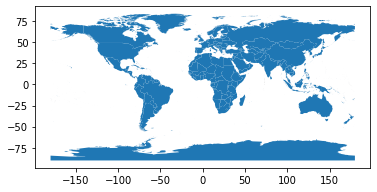

In [91]:
world = gpd.GeoDataFrame.from_file("TM_WORLD_BORDERS_SIMPL-0.3.shp")

infected["totalinfected"] = infected[infected.columns[-1]]
infected = addlogbydate(infected)

data, key = get_dataset(day=24, df=infected)
data = gpd.GeoDataFrame(data.groupby("NAME").sum().reset_index(
    ).merge(data[["NAME", "geometry"]].drop_duplicates(subset="NAME"), 
            on="NAME", how="left")).plot()

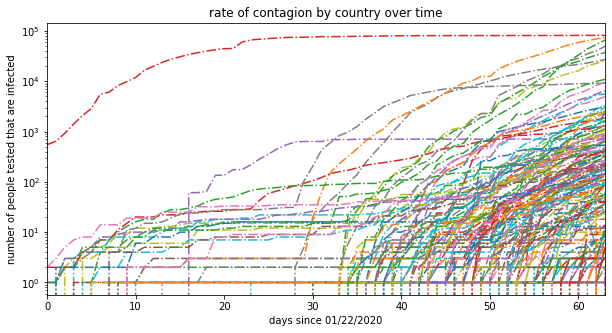

In [92]:
# the rate of contagion by country over time
def getcountry (df, country):
  return df[df["Country/Region"] == country].set_index("Country/Region")[
                  df.columns[3:N+3]].T.reset_index()

fig, ax = pl.subplots(1, 1, figsize=(10,5))
for country in infected["Country/Region"].values:

  tmp = getcountry(infected, country)#.set_index("Country/Region")
  tmp.plot(style="-.", 
           ax=ax, label=None,
           legend=False,
           #label=country, 
           figsize=(10,5))
pl.yscale("log")
pl.ylabel("number of people tested that are infected")
pl.xlabel("days since 01/22/2020")
pl.title("rate of contagion by country over time");

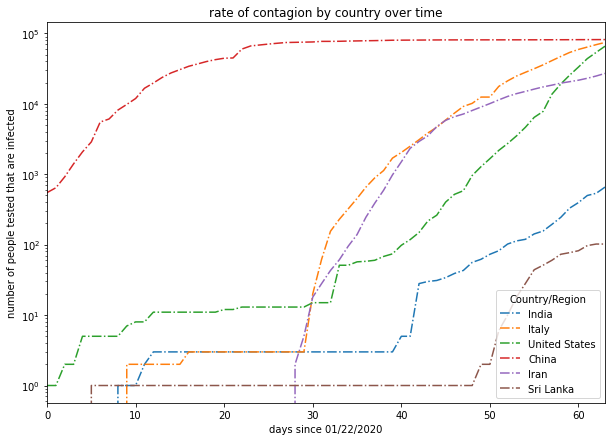

In [93]:
india = getcountry(infected, 'India')
italy = getcountry(infected, 'Italy')
us = getcountry(infected, 'United States')
china = getcountry(infected, 'China')
iran = getcountry(infected, 'Iran')
srl = getcountry(infected, 'Sri Lanka')

fig, ax = pl.subplots(1, 1, figsize=(10,7))

india.plot(style="-.", ax=ax,label='India', figsize=(10,7))
italy.plot(style="-.", ax=ax, label='Italy', figsize=(10,7))
us.plot(style="-.", ax=ax, label='US', figsize=(10,7))
china.plot(style="-.", ax=ax, label='China', figsize=(10,7))
iran.plot(style="-.", ax=ax, label='Iran', figsize=(10,7))
srl.plot(style="-.", ax=ax, label='Sri Lanka', figsize=(10,7))

pl.yscale("log")
pl.ylabel("number of people tested that are infected")
pl.xlabel("days since 01/22/2020")
pl.title("rate of contagion by country over time");
#plt.figure()
#plt.plot(india)

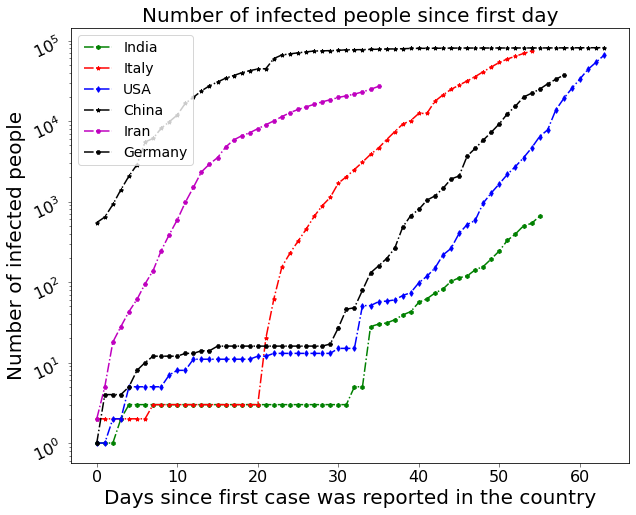

In [94]:
india = getcountry(infected, 'India')
italy = getcountry(infected, 'Italy')
us = getcountry(infected, 'United States')
china = getcountry(infected, 'China')
iran = getcountry(infected, 'Iran')
germany = getcountry(infected, 'Germany')

idx_ind = where( india.India > 0 )[0]
idx_itl = where( italy.Italy > 0 )[0]
idx_usa = where( us['United States'] > 0 )[0]
idx_chn = where( china.China > 0 )[0]
idx_irn = where( iran.Iran > 0 )[0]
idx_grn = where( germany.Germany > 0 )[0]

ls = '-.'
ms = 4

fig, ax = pl.subplots(1, 1, figsize=(10,8))

ax.plot( arange(len(idx_ind)), india.India[idx_ind], 'gh', label='India', ms=ms, ls=ls )
ax.plot( arange(len(idx_itl)), italy.Italy[idx_itl],  'r*', label='Italy', ms=ms, ls=ls )
ax.plot( arange(len(idx_usa)), us['United States'][idx_usa], 'bd', label='USA', ms=ms, ls=ls )
ax.plot( arange(len(idx_chn)), china.China[idx_chn],  'k*', label='China', ms=ms, ls=ls )
ax.plot( arange(len(idx_irn)), iran.Iran[idx_irn], 'mH', label='Iran', ms=ms, ls=ls )
ax.plot( arange(len(idx_grn)), germany.Germany[idx_grn], 'kH', label='Germany', ms=ms, ls=ls )

ax.set_ylabel('Number of infected people', fontsize=20)
ax.set_xlabel('Days since first case was reported in the country', fontsize=20)
ax.set_title('Number of infected people since first day', fontsize=20)
ax.set_yscale('log')

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=25 )

ax.legend(loc=2, fontsize=14);
